In [1]:
# Cell 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# Output directory
OUTPUT_DIR = Path("first")
OUTPUT_DIR.mkdir(exist_ok=True)


In [2]:
# Cell 2: Load and preprocess Adult dataset

# Column names as per dataset description
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Load data from local path
df = pd.read_csv('adult/adult.data', names=columns, sep=',', skipinitialspace=True)

print(len(df))

print(df.nunique())

# Drop unnecessary columns
df = df.drop(columns=['fnlwgt', 'education', 'capital-gain', 'capital-loss'])

# Encode target
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Encode categorical features (except 'sex', which is our sensitive attribute)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('sex')  # keep sex for fairness analysis
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode 'sex' as well for modeling
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Split features and target
X = df.drop(columns=['income'])
y = df['income']
sensitive = X['sex']  # male=1, female=0

# Train-test split
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


32561
age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income                2
dtype: int64


In [3]:
print(df['relationship'].unique())
print(df['education-num'].unique())

[1 0 5 3 4 2]
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


In [4]:
# Cell 2.5: Exploratory Data Analysis - Income and Gender Distribution (Separate Images)

# Prepare data for plotting
df_plot = df.copy()
df_plot['sex'] = df_plot['sex'].map({1: 'Male', 0: 'Female'})
df_plot['income'] = df_plot['income'].map({1: '>50K', 0: '<=50K'})

# 1. Income distribution by gender (left graph)
plt.figure(figsize=(8,6))
sns.countplot(data=df_plot, x='sex', hue='income', palette=['lightcoral', 'skyblue'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Income Distribution by Gender")
plt.legend(title='Income')

# Add value labels on top of bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

# Save left graph
left_plot_path = OUTPUT_DIR / "income_distribution_by_gender.png"
plt.tight_layout()
plt.savefig(left_plot_path)
plt.close()

# 2. Sample distribution of gender (right graph)
plt.figure(figsize=(8,6))
sns.countplot(data=df_plot, x='sex', palette=['skyblue', 'lightcoral'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Sample Distribution by Gender")

# Add value labels on top of bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

# Save right graph
right_plot_path = OUTPUT_DIR / "sample_distribution_by_gender.png"
plt.tight_layout()
plt.savefig(right_plot_path)
plt.close()

print(f"Left graph saved to: {left_plot_path}")
print(f"Right graph saved to: {right_plot_path}")


Left graph saved to: first/income_distribution_by_gender.png
Right graph saved to: first/sample_distribution_by_gender.png


/var/folders/88/jmf8wmrx2492bxbr1s_mj_2d126js3/T/ipykernel_15702/2899280160.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x='sex', palette=['skyblue', 'lightcoral'])


In [5]:
# Cell 3: Train baseline models (without SVC and Neural Network)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    
    # Store results as dictionary for later use
    results[name] = {
        'model': model,
        'test_accuracy': acc
    }
    predictions[name] = y_pred
    
    # Fairness metrics
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_ratio = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
    
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Demographic Parity Ratio: {dp_ratio:.4f}")
    print(f"Equalized Odds Difference: {eo_diff:.4f}")
    print(f"Equalized Odds Ratio: {eo_ratio:.4f}\n")


Training Logistic Regression...
Test Accuracy: 0.8051
Demographic Parity Difference: 0.1845
Demographic Parity Ratio: 0.1033
Equalized Odds Difference: 0.4025
Equalized Odds Ratio: 0.1219

Training Random Forest...
Test Accuracy: 0.8192
Demographic Parity Difference: 0.1802
Demographic Parity Ratio: 0.3408
Equalized Odds Difference: 0.0952
Equalized Odds Ratio: 0.3109

Training Gradient Boosting...
Test Accuracy: 0.8410
Demographic Parity Difference: 0.1743
Demographic Parity Ratio: 0.2982
Equalized Odds Difference: 0.1122
Equalized Odds Ratio: 0.2345

Training XGBoost...


/Users/sgurung/Desktop/Trustworthy Machine Learning/Project/Project 3/my_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [05:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.8433
Demographic Parity Difference: 0.1785
Demographic Parity Ratio: 0.3429
Equalized Odds Difference: 0.0956
Equalized Odds Ratio: 0.3252

Training KNN...
Test Accuracy: 0.8126
Demographic Parity Difference: 0.1905
Demographic Parity Ratio: 0.3225
Equalized Odds Difference: 0.1130
Equalized Odds Ratio: 0.2865



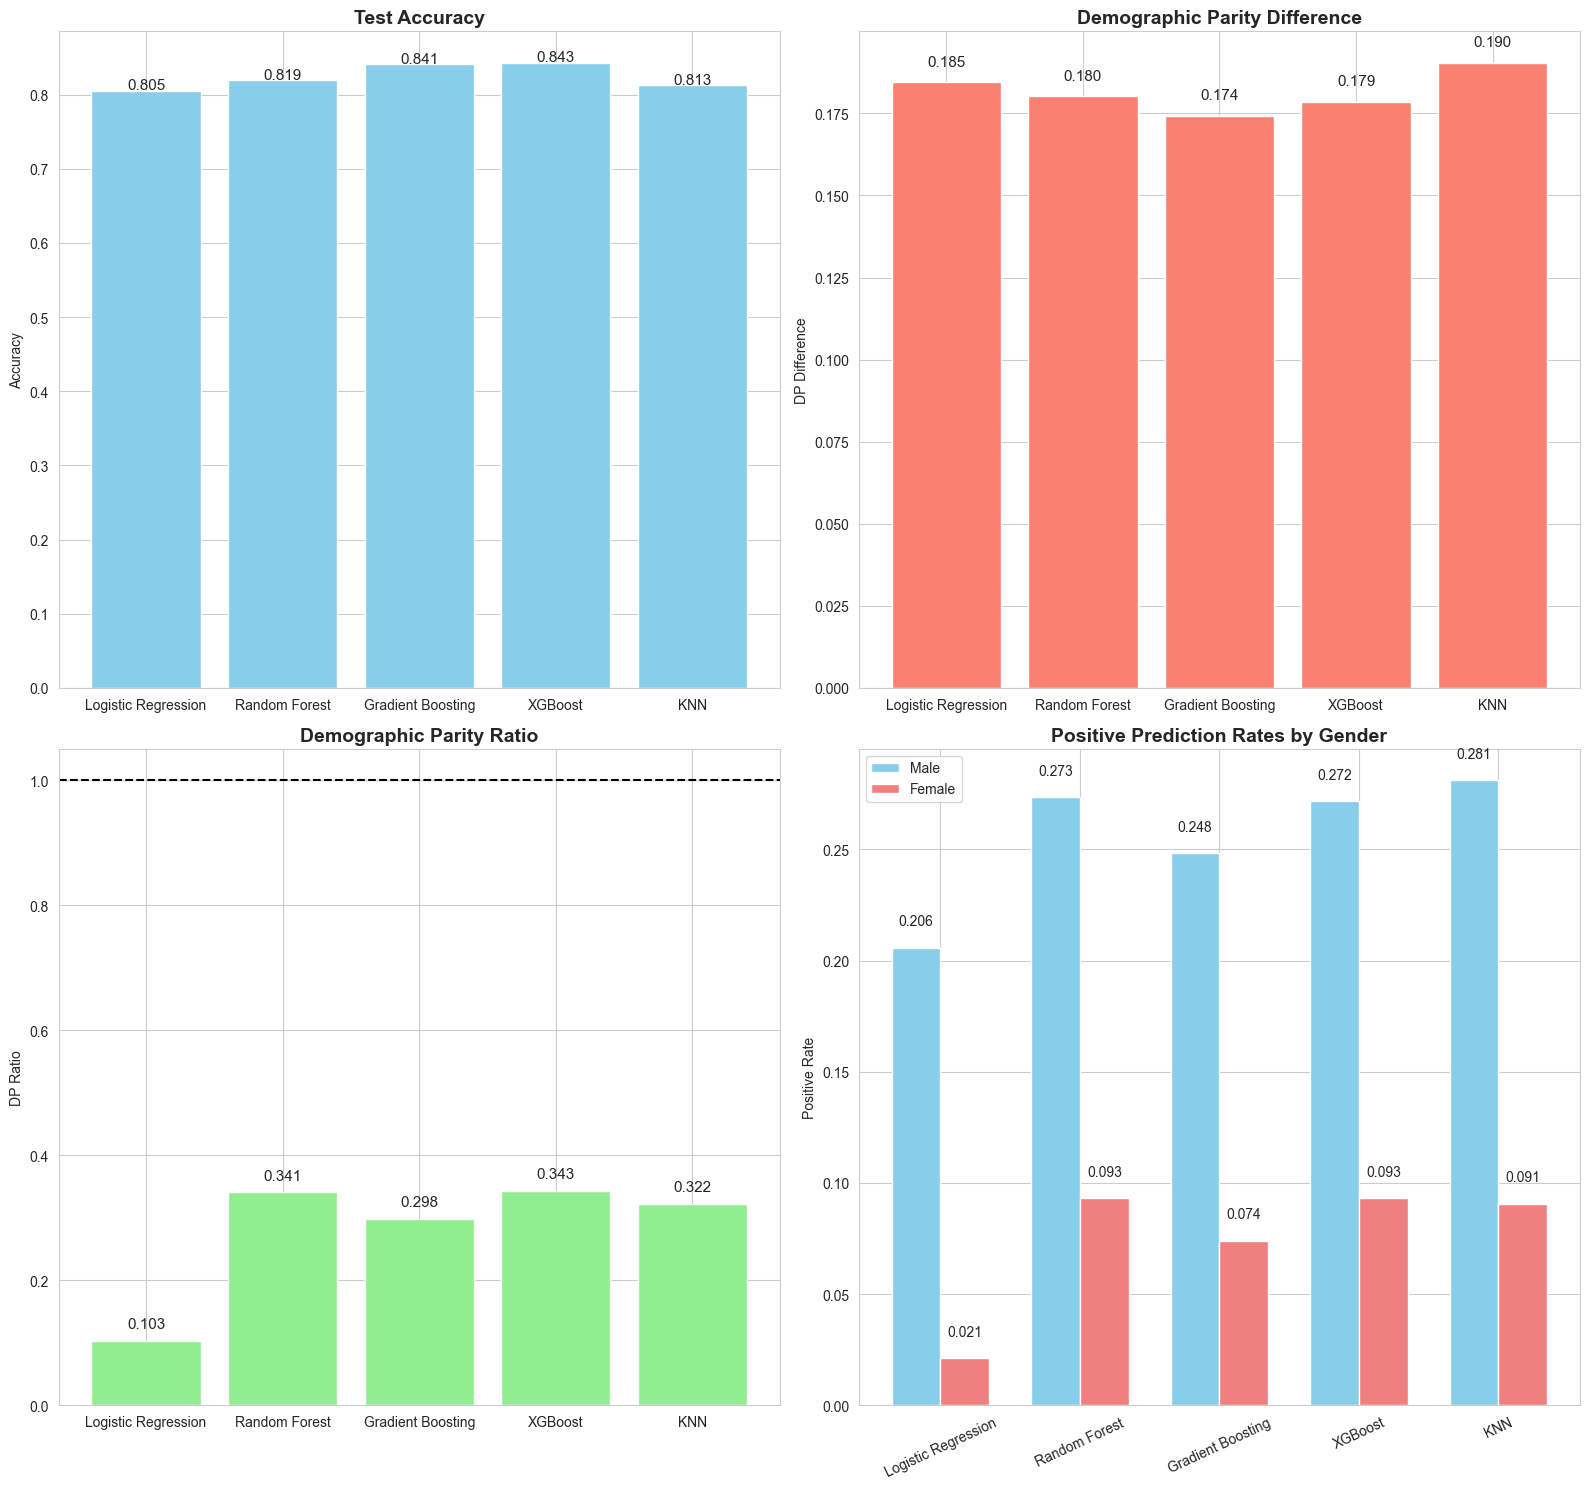

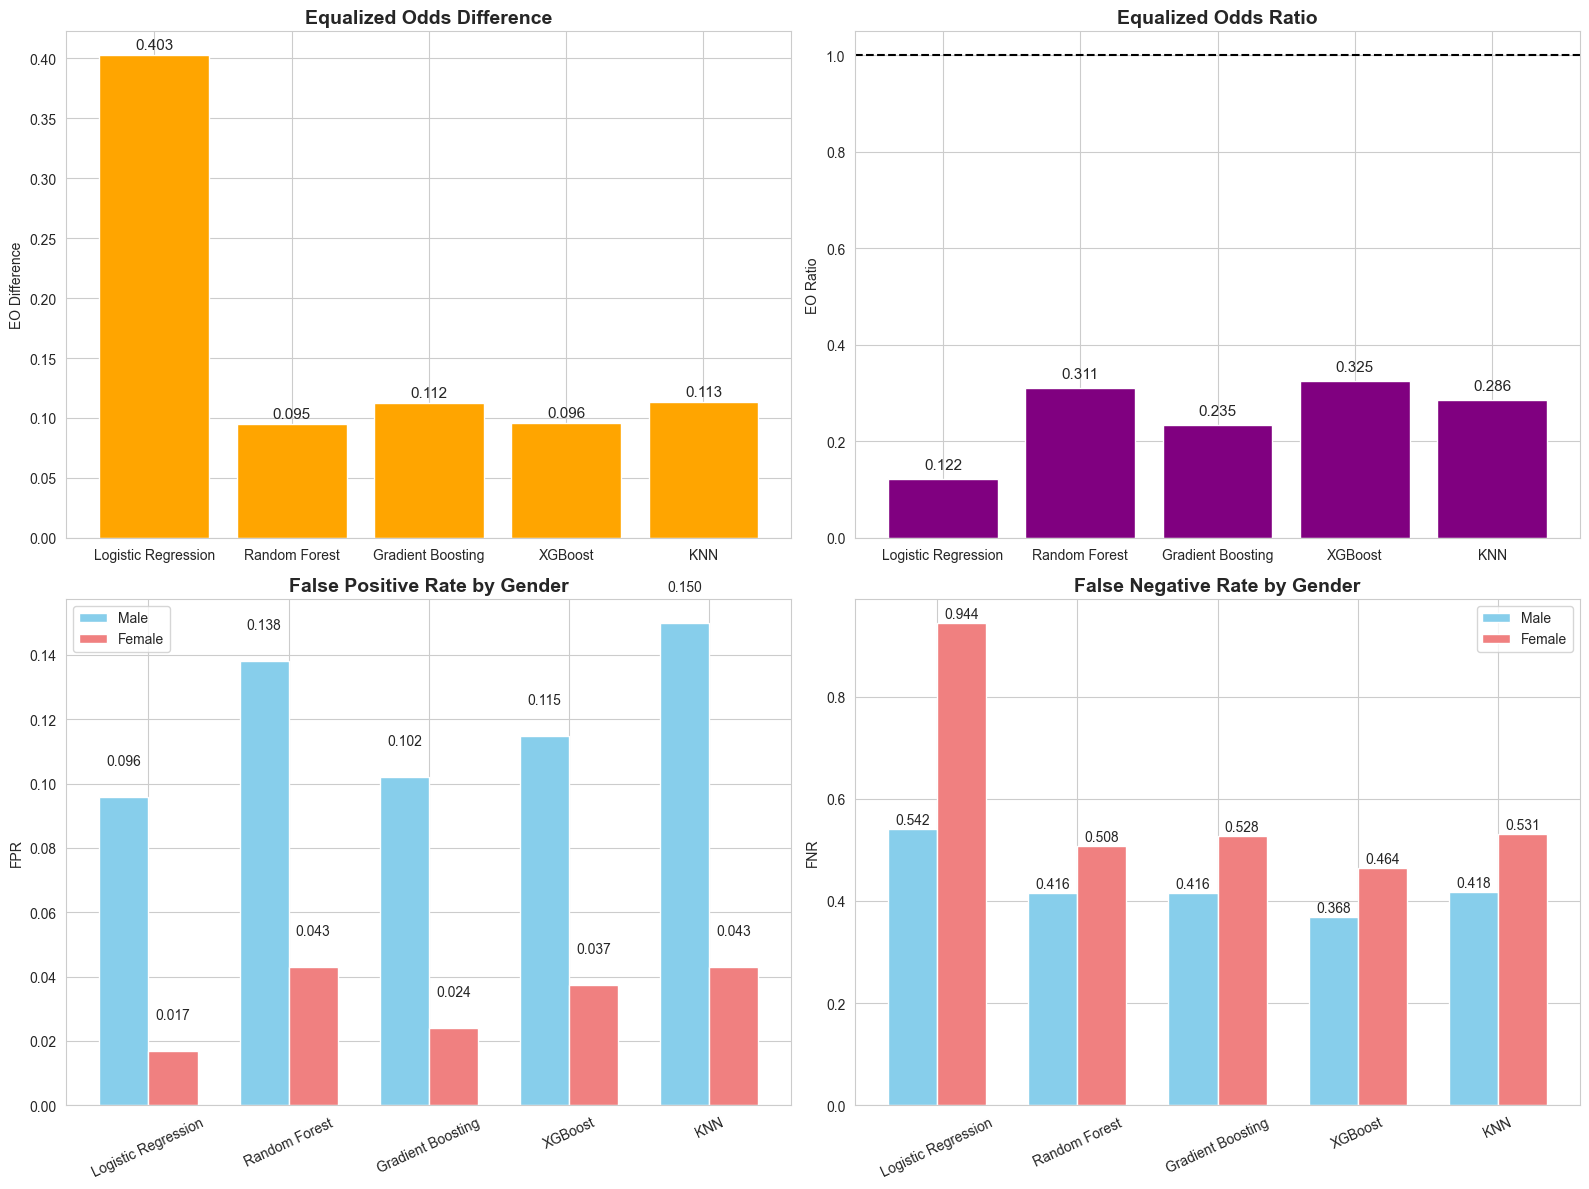

In [6]:
# Cell 4: Visualize results with 2x2 subplots (with y-axis labels)

# Prepare metrics
dp_diffs, dp_ratios, eo_diffs, eo_ratios = [], [], [], []
male_pos_rates, female_pos_rates = [], []
male_fpr, female_fpr, male_fnr, female_fnr = [], [], [], []

for name, y_pred in predictions.items():
    # Fairness metrics
    dp_diffs.append(demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test))
    dp_ratios.append(demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test))
    eo_diffs.append(equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test))
    eo_ratios.append(equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test))
    
    # Positive prediction rates
    df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred, 'sex': sensitive_test})
    pred_by_gender = df_pred.groupby('sex')['y_pred'].mean()
    male_pos_rates.append(pred_by_gender[1])
    female_pos_rates.append(pred_by_gender[0])
    
    # FPR and FNR by gender
    from sklearn.metrics import confusion_matrix
    for gender, fpr_list, fnr_list in [(1, male_fpr, male_fnr), (0, female_fpr, female_fnr)]:
        group = df_pred[df_pred['sex'] == gender]
        tn, fp, fn, tp = confusion_matrix(group['y_true'], group['y_pred']).ravel()
        fpr_list.append(fp / (fp + tn))
        fnr_list.append(fn / (fn + tp))

model_names = list(results.keys())

# ---------------------- First figure: Accuracy + Parity metrics ----------------------
fig, axes = plt.subplots(2, 2, figsize=(16,15))

# Test Accuracy
axes[0,0].bar(model_names, [r['test_accuracy'] for r in results.values()], color='skyblue')
axes[0,0].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
for i, acc in enumerate([r['test_accuracy'] for r in results.values()]):
    axes[0,0].text(i, acc + 0.002, f"{acc:.3f}", ha='center', fontsize=11)

# Demographic Parity Difference
axes[0,1].bar(model_names, dp_diffs, color='salmon')
axes[0,1].set_title('Demographic Parity Difference', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('DP Difference')
for i, val in enumerate(dp_diffs):
    axes[0,1].text(i, val + 0.005, f"{val:.3f}", ha='center', fontsize=11)

# Demographic Parity Ratio
axes[1,0].bar(model_names, dp_ratios, color='lightgreen')
axes[1,0].axhline(1.0, color='black', linestyle='--')
axes[1,0].set_title('Demographic Parity Ratio', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('DP Ratio')
for i, val in enumerate(dp_ratios):
    axes[1,0].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)

# Positive Prediction Rates by Gender
x = np.arange(len(model_names))
width = 0.35
axes[1,1].bar(x - width/2, male_pos_rates, width, label='Male', color='skyblue')
axes[1,1].bar(x + width/2, female_pos_rates, width, label='Female', color='lightcoral')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(model_names, rotation=25)
axes[1,1].set_title('Positive Prediction Rates by Gender', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Positive Rate')
axes[1,1].legend()
for i in range(len(model_names)):
    axes[1,1].text(i - width/2, male_pos_rates[i]+0.01, f"{male_pos_rates[i]:.3f}", ha='center', fontsize=10)
    axes[1,1].text(i + width/2, female_pos_rates[i]+0.01, f"{female_pos_rates[i]:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------- Second figure: Equalized Odds + FPR/FNR ----------------------
fig, axes = plt.subplots(2, 2, figsize=(16,12))

# Equalized Odds Difference
axes[0,0].bar(model_names, eo_diffs, color='orange')
axes[0,0].set_title('Equalized Odds Difference', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('EO Difference')
for i, val in enumerate(eo_diffs):
    axes[0,0].text(i, val + 0.005, f"{val:.3f}", ha='center', fontsize=11)

# Equalized Odds Ratio
axes[0,1].bar(model_names, eo_ratios, color='purple')
axes[0,1].axhline(1.0, color='black', linestyle='--')
axes[0,1].set_title('Equalized Odds Ratio', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('EO Ratio')
for i, val in enumerate(eo_ratios):
    axes[0,1].text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)

# FPR by Gender
axes[1,0].bar(x - width/2, male_fpr, width, label='Male', color='skyblue')
axes[1,0].bar(x + width/2, female_fpr, width, label='Female', color='lightcoral')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(model_names, rotation=25)
axes[1,0].set_title('False Positive Rate by Gender', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('FPR')
axes[1,0].legend()
for i in range(len(model_names)):
    axes[1,0].text(i - width/2, male_fpr[i]+0.01, f"{male_fpr[i]:.3f}", ha='center', fontsize=10)
    axes[1,0].text(i + width/2, female_fpr[i]+0.01, f"{female_fpr[i]:.3f}", ha='center', fontsize=10)

# FNR by Gender
axes[1,1].bar(x - width/2, male_fnr, width, label='Male', color='skyblue')
axes[1,1].bar(x + width/2, female_fnr, width, label='Female', color='lightcoral')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(model_names, rotation=25)
axes[1,1].set_title('False Negative Rate by Gender', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('FNR')
axes[1,1].legend()
for i in range(len(model_names)):
    axes[1,1].text(i - width/2, male_fnr[i]+0.01, f"{male_fnr[i]:.3f}", ha='center', fontsize=10)
    axes[1,1].text(i + width/2, female_fnr[i]+0.01, f"{female_fnr[i]:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [7]:
# Cell 4: Save each subplot as an individual image in 'first' folder

import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
x = np.arange(len(model_names))
width = 0.35

# ---------------------- First figure set ----------------------
# 1. Test Accuracy
plt.figure(figsize=(8,6))
plt.bar(model_names, [r['test_accuracy'] for r in results.values()], color='skyblue')
plt.title('Test Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
for i, acc in enumerate([r['test_accuracy'] for r in results.values()]):
    plt.text(i, acc + 0.002, f"{acc:.3f}", ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "test_accuracy.png")
plt.close()

# 2. Demographic Parity Difference
plt.figure(figsize=(8,6))
plt.bar(model_names, dp_diffs, color='salmon')
plt.title('Demographic Parity Difference', fontsize=14, fontweight='bold')
plt.ylabel('DP Difference')
for i, val in enumerate(dp_diffs):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "dp_difference.png")
plt.close()

# 3. Demographic Parity Ratio
plt.figure(figsize=(8,6))
plt.bar(model_names, dp_ratios, color='lightgreen')
plt.axhline(1.0, color='black', linestyle='--')
plt.title('Demographic Parity Ratio', fontsize=14, fontweight='bold')
plt.ylabel('DP Ratio')
for i, val in enumerate(dp_ratios):
    plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "dp_ratio.png")
plt.close()

# 4. Positive Prediction Rates by Gender
plt.figure(figsize=(8,6))
plt.bar(x - width/2, male_pos_rates, width, label='Male', color='skyblue')
plt.bar(x + width/2, female_pos_rates, width, label='Female', color='lightcoral')
plt.xticks(x, model_names, rotation=25)
plt.title('Positive Prediction Rates by Gender', fontsize=14, fontweight='bold')
plt.ylabel('Positive Rate')
plt.legend()
for i in range(len(model_names)):
    plt.text(i - width/2, male_pos_rates[i]+0.01, f"{male_pos_rates[i]:.3f}", ha='center', fontsize=10)
    plt.text(i + width/2, female_pos_rates[i]+0.01, f"{female_pos_rates[i]:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "positive_prediction_rates.png")
plt.close()

# ---------------------- Second figure set ----------------------
# 5. Equalized Odds Difference
plt.figure(figsize=(8,6))
plt.bar(model_names, eo_diffs, color='orange')
plt.title('Equalized Odds Difference', fontsize=14, fontweight='bold')
plt.ylabel('EO Difference')
for i, val in enumerate(eo_diffs):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eo_difference.png")
plt.close()

# 6. Equalized Odds Ratio
plt.figure(figsize=(8,6))
plt.bar(model_names, eo_ratios, color='purple')
plt.axhline(1.0, color='black', linestyle='--')
plt.title('Equalized Odds Ratio', fontsize=14, fontweight='bold')
plt.ylabel('EO Ratio')
for i, val in enumerate(eo_ratios):
    plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eo_ratio.png")
plt.close()

# 7. FPR by Gender
plt.figure(figsize=(8,6))
plt.bar(x - width/2, male_fpr, width, label='Male', color='skyblue')
plt.bar(x + width/2, female_fpr, width, label='Female', color='lightcoral')
plt.xticks(x, model_names, rotation=25)
plt.title('False Positive Rate by Gender', fontsize=14, fontweight='bold')
plt.ylabel('FPR')
plt.legend()
for i in range(len(model_names)):
    plt.text(i - width/2, male_fpr[i]+0.01, f"{male_fpr[i]:.3f}", ha='center', fontsize=10)
    plt.text(i + width/2, female_fpr[i]+0.01, f"{female_fpr[i]:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "fpr_by_gender.png")
plt.close()

# 8. FNR by Gender
plt.figure(figsize=(8,6))
plt.bar(x - width/2, male_fnr, width, label='Male', color='skyblue')
plt.bar(x + width/2, female_fnr, width, label='Female', color='lightcoral')
plt.xticks(x, model_names, rotation=25)
plt.title('False Negative Rate by Gender', fontsize=14, fontweight='bold')
plt.ylabel('FNR')
plt.legend()
for i in range(len(model_names)):
    plt.text(i - width/2, male_fnr[i]+0.01, f"{male_fnr[i]:.3f}", ha='center', fontsize=10)
    plt.text(i + width/2, female_fnr[i]+0.01, f"{female_fnr[i]:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "fnr_by_gender.png")
plt.close()

print("All 8 subplots saved individually in the 'first' folder.")


All 8 subplots saved individually in the 'first' folder.
